In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV
from torchlake.object_detection.models.ssd import SSD, MultiBoxLoss
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path

# setting

In [3]:
artifact_path = Path('../../artifacts/ssd')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = [4, 6, 6, 6, 4, 4]

In [6]:
CONTEXT = DetectorContext(
    detector_name="ssd",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
    anchors_path=artifact_path.joinpath("anchors.txt").as_posix(),
)

# data

In [7]:
BATCH_SIZE = 32

In [8]:
IMAGE_SIZE = 300

In [9]:
transform = A.Compose(
    [
        # A.ColorJitter(p=0.5),
        A.HorizontalFlip(p=0.5),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        # A.RandomSizedBBoxSafeCrop(input_size, input_size),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
train_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_trainval.csv"),
    transform=transform,
)

In [11]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 300, 300]) 1


In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [13]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([32, 3, 300, 300]) 32


In [14]:
# for _, y in train_loader:
#     for ele in y:
#         assert len(ele) > 0, ele

# model

In [15]:
model = SSD(CONTEXT, trainable=False).to(CONTEXT.device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
SSD                                                --
├─Backbone: 1-1                                    --
│    └─VGGFeatureExtractor: 2-1                    --
│    │    └─Sequential: 3-1                        22,943,424
│    │    └─ImageNetNormalization: 3-2             --
│    └─L2Norm: 2-2                                 512
├─ModuleList: 1-2                                  --
│    └─RegHead: 2-3                                --
│    │    └─Conv2d: 3-3                            73,744
│    │    └─Conv2d: 3-4                            387,156
│    └─RegHead: 2-4                                --
│    │    └─Conv2d: 3-5                            221,208
│    │    └─Conv2d: 3-6                            1,161,342
│    └─RegHead: 2-5                                --
│    │    └─Conv2d: 3-7                            110,616
│    │    └─Conv2d: 3-8                            580,734
│    └─RegHead: 2-6                  

# train

In [17]:
EPOCH = 10

In [18]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # TODO: lower lr
criterion = MultiBoxLoss(CONTEXT)

In [20]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [21]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 517/517 [04:05<00:00,  2.11it/s]


epoch 1 : 0.3237699098755359


100%|██████████| 517/517 [04:00<00:00,  2.15it/s]


epoch 2 : 0.2041564220040172


100%|██████████| 517/517 [04:01<00:00,  2.14it/s]


epoch 3 : 0.19539192497614966


100%|██████████| 517/517 [04:00<00:00,  2.15it/s]


epoch 4 : 0.1909645696673218


100%|██████████| 517/517 [03:59<00:00,  2.16it/s]


epoch 5 : 0.18757661883097784


100%|██████████| 517/517 [04:01<00:00,  2.14it/s]


epoch 6 : 0.1849533277969065


100%|██████████| 517/517 [03:51<00:00,  2.24it/s]


epoch 7 : 0.1823418302104828


100%|██████████| 517/517 [04:00<00:00,  2.15it/s]


epoch 8 : 0.1686081535811581


100%|██████████| 517/517 [03:56<00:00,  2.19it/s]


epoch 9 : 0.1655772807980875


100%|██████████| 517/517 [04:26<00:00,  1.94it/s]

epoch 10 : 0.16423541082634915


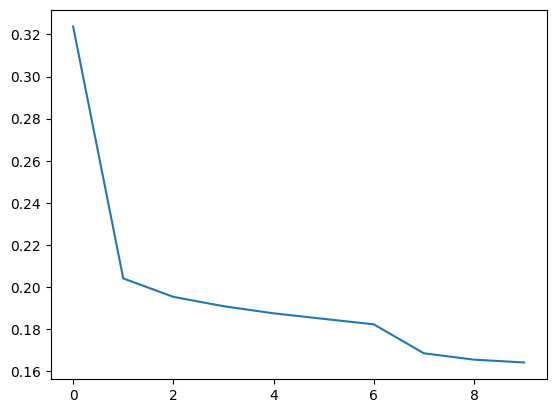

In [40]:
plt.plot(training_loss)

In [41]:
model_path = artifact_path / f'ssd.{IMAGE_SIZE}.10.pth'

In [42]:
torch.save(model.state_dict(), model_path)

In [43]:
get_file_size(model_path)

'100.3MiB'

In [44]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# inference

In [45]:
from tqdm import tqdm
from torchlake.object_detection.models.ssd.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [46]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [47]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [48]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [49]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [50]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [51]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [52]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [53]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B, C+1, H, W
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/154 [00:02<?, ?it/s]


In [54]:
# for i in range(len(output)):
#     output[i] = torch.cat([output[i][:, :4], torch.zeros((output[i].size(0), 1)), output[i][:, 4:24]],1)

In [56]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

bird: 0.37
dog: 0.56
dog: 0.30
motorbike: 0.31
person: 0.33
person: 0.53
aeroplane: 0.49
aeroplane: 0.34
dog: 0.70
person: 0.36
bus: 0.70
bird: 0.40
bird: 0.33
person: 0.45
person: 0.36
person: 0.37
person: 0.36
person: 0.30
dog: 0.36
dog: 0.38
bird: 0.32
bird: 0.35
bird: 0.37
dog: 0.60
person: 0.40
car: 0.39
car: 0.62
bicycle: 0.33
horse: 0.50
person: 0.54
person: 0.37
person: 0.48
diningtable: 0.36
person: 0.46
person: 0.38
person: 0.40
person: 0.81
bicycle: 0.70
bird: 0.53
car: 0.39
car: 0.31
car: 0.63
car: 0.38
bird: 0.33


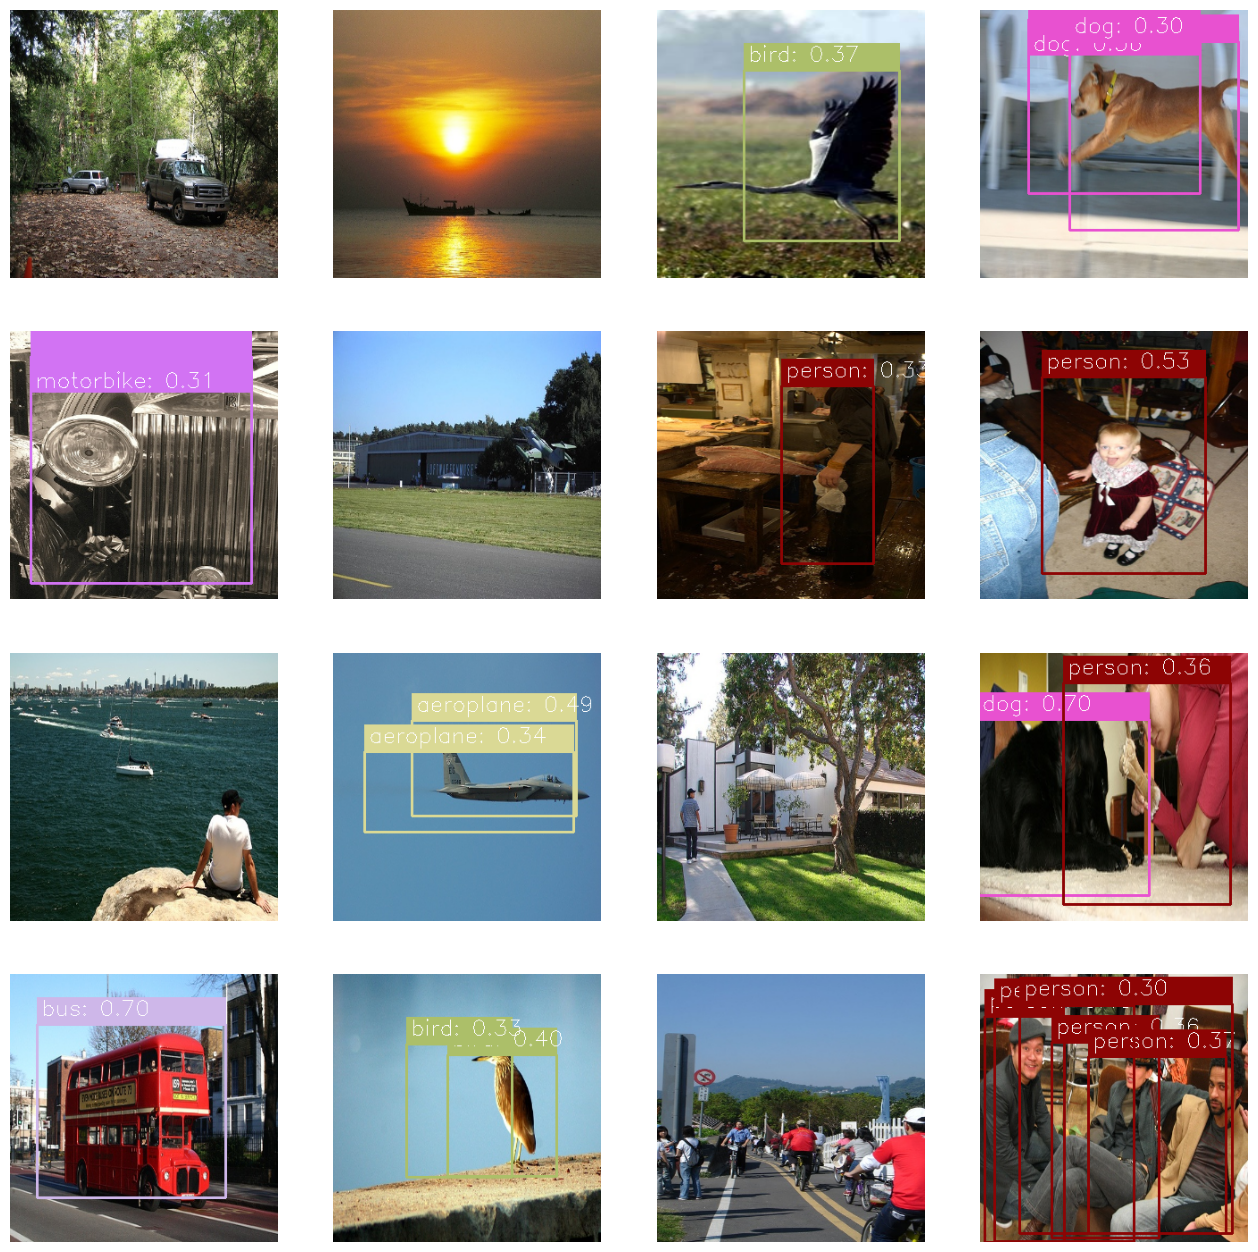

In [57]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [69]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.36
person: 0.51
person: 0.46
person: 0.59
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 4
person: 0.49
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.56
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 1


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

# evaluation

In [60]:
from torchlake.object_detection.models.ssd.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [61]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [62]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [63]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [64]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [65]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [66]:
evaluator = Evaluator(CONTEXT)

In [67]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 154/154 [04:52<00:00,  1.90s/it]


       aeroplane   bicycle      bird      boat    bottle       bus       car  \
AP@0.5  0.415259  0.337778  0.307368  0.291904  0.228407  0.236139  0.248186   

             cat     chair      cow  ...      dog     horse motorbike  \
AP@0.5  0.310097  0.245709  0.24332  ...  0.30433  0.309095  0.310075   

          person pottedplant    sheep      sofa     train tvmonitor       all  
AP@0.5  0.280841    0.277725  0.27599  0.276977  0.280709    0.2794  0.287749  

[1 rows x 21 columns]


In [68]:
result_table.T

,AP@0.5
aeroplane,0.415259
bicycle,0.337778
bird,0.307368
boat,0.291904
bottle,0.228407
bus,0.236139
car,0.248186
cat,0.310097
chair,0.245709
cow,0.24332


In [ ]:
for path in artifact_path.joinpath(evaluator.cfg.MODEL.BACKBONE).glob("*.pth"):
    model.load_state_dict(torch.load(path))

    evaluator.run(
        predictor,
        model,
        test_loader,
        VOC_CLASS_NAMES,
        save_dir=artifact_path.as_posix(),
        output_filename=f"{path.stem}.eval.csv",
    )